# Chapter 6: 학습 관련 기술들
>  
> ### ** 6.1** 매개변수 갱신  
> * 신경망 학습의 목적은 손실 함수의 값을 가능한 한 낮추는 매개변수를 찾는 것  
> &nbsp; &nbsp; &rarr; 이는 곧 매개변수의 최적값을 찾는 문제이며, 이러한 문제를 푸는 것을 최적화라고 함
> * 지금까지 최적의 매개변수 값을 찾는 단서로 매개변수의 기울기(미분)을 이용함  
> 매개변수의 기울기를 구해, 기울어진 방향으로 매개변수 값을 갱신하는 일을 반복해서 점점 최적의 값에 다가감  
> &nbsp; &nbsp; &rarr; 확률적 경사 하강법 (SGD)
> * SGD는 매개변수 공간을 무작정 찾는 것보다 '똑똑한' 방법이지만, 문제에 따라서는 SGD보다 똑똑한 방법도 있음

>> ##### 모험가 이야기
>> ![adventure](adventure.png)
>> * 위와 같은 어려운 상황에서 중요한 단서가 되는 것이 땅의 '기울기'
>> * 모험가는 주위 경치는 볼 수 없지만 지금 서 있는 땅의 기울기는 알 수 있음
>> * 지금 서 있는 장소에서 가장 크게 기울어진 방향으로 가는 것이 SGD의 전략  
>> 이를 반복하면 언젠가 '깊은 곳'에 찾아갈 수 있을 것
>>  
>> ##### 확률적 경사 하강법 (SGD)
>> SGD 복습  
>> * $ W \larr W- \eta \frac{\sigma L}{\sigma W} $  
>>      * $W$: 갱신할 가중치 매개변수  
>>      * $\frac{\sigma L}{\sigma W}$: $W$에 대한 손실함수의 기울기  
>>      * $\eta$: 학습률 (0.01이나 0.001과 같은 값을 미리 정해서 사용)  
>>      * $\larr$: 우변의 값으로 좌변의 값을 갱신

In [1]:
# SGD 구현
class SGD:
    def __init__(self, lr=0.01):
        self.lr = lr
    
    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr*grads[key]

>> * 초기화 때 받는 인수 lr: learning rate(학습률)  
>> 이 학습률을 인스턴스 변수로 유지  
>> * `update(params, grads)` 메서드: SGD 과정에서 반복해서 호출
>>      * `params, grads`: 딕셔너리 변수  
>> `params['W1'], grads['W1']` 등과 같이 각각 가중치 매개변수와 기울기를 저장하고 있음
>>  
>> SGD 클래스를 사용하면 신경망 매개변수의 진행을 다음과 같이 수행할 수 있음  
>> ```
>> network = TwoLayerNet(...)  
>> optimizer = SGD()  
>>  
>> for i in range(10000):  
>> ...  
>> x_batch, t_batch = get_mini_batch(...) # 미니배치  
>> grads = network.gradient(x_batch, t_batch)  
>> params = network.params  
>> optimizer.update(params, grads)  
>> ...
>> ```
>> * optimizer: 최적화를 행하는 자, 매개변수 갱신을 수행
>>  
>> * 이처럼 최적화를 담당하는 클래스를 분리해 구현하면 기능을 모듈화하기 좋음

>> ##### SGD의 단점
>> * 문제에 따라서 비효율적인 경우가 있음  
>> ![disad_sgd](disad_sgd.png)
>> ![gradient_disad](gradient_disad.png)
>>  
>> SGD 적용
>> * 탐색 시작 (초깃값) $(x,y) = (-7.0, 2.0)$  
>> ![disad_application_of_sgd](disad_application_of_sgd.png)
>>  
>> * SGD는 그림 6-3과 같은 심하게 굽이진 움직임을 보여줌  
>> &nbsp; &nbsp; &rarr; 상당히 비효율적인 움직임  
>> &nbsp; &nbsp; &rarr; SGD의 단점은 비등방성 함수(anisotropy function)에서는 탐색 경로가 비효율적이라는 것  
>> &nbsp; &nbsp; &nbsp; &nbsp; (anisotropy function: 방향에 따라 성질, 즉 여기에서는 기울기가 달라지는 함수)
>>  
>> * SGD가 지그재그로 탐색하는 근본 원인은 기울어진 방향이 본래의 최솟값과 다른 방향을 가리키기 때문
>> * SGD의 이러한 단점을 개선해주는 기법: Momentum, AdaGrad, Adam

>> ##### Momentum
>> * Momentum: 운동량, 물리와 관계가 있음  
>>  
>> * $ v \larr \alpha v - \eta \frac{\sigma L}{\sigma W} $ &nbsp; &nbsp; &nbsp; [식 6.3]
>> * $ W \larr W+v $ &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; [식 6.4]
>>      * $W$: 갱신할 가중치 매개변수  
>>      * $\frac{\sigma L}{\sigma W}$: $W$에 대한 손실 함수의 기울기
>>      * $\eta$: 학습률
>>      * $v$: 물리에서 말하는 속도
>> * 식 6.3은 기울기 방향으로 힘을 받아 물체가 가속되는 물리 법칙을 나타냄  
>> * 식 6.3의 $\alpha v$ 항은 물체가 아무런 힘을 받지 않을 때 서서히 하강시키는 역할을 함  
>> 물리에서의 마찰, 공기 저항에 해당  
>> * 모멘텀은 공이 그릇의 바닥을 구르는 듯한 움직임을 보여줌  
>> ![momentum_image](momentum_image.png)

In [2]:
import numpy as np

# Momentum 구현
class Momentum:
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
    
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)
            
        for key in params.keys():
            self.v[key] = self.momentum*self.v[key]-self.lr*grads[key]
            params[key] += self.v[key]

>> * 인스턴스 변수 v: 물체의 속도, 초기화 때는 아무 값도 담지 않음, update()가 처음 호출될 때 매개변수와 같은 구조의 데이터를 딕셔너리 변수로 저장
>>  
>> * 나머지 부분은 식 6.3과 식 6.4를 코드로 옮긴 것
>>  
>> ![optimize_momentum](optimize_momentum.png)
>>  
>> * 그림에서 보듯 모멘텀의 갱신 경로는 공이 그릇 바닥을 구르듯 움직임
>>  
>> * SGD와 비교하면 '지그재그 정도'가 덜함
>> * 이는 x축의 힘은 아주 작지만 방향은 변하지 않아서 한 방향으로 일정하게 가속하기 때문
>> * y축의 힘은 크지만 위아래로 번갈아 받아서 상충하여 y축 방향의 속도는 안정적이지 않음
>> * 전체적으로는 SGD보다 x축 방향으로 빠르게 다가가 지그재그 움직임이 줄어듦

>> ##### AdaGrad
>> 신경망 학습에서는 학습률 (수식에서는 $\eta$로 표기) 값이 중요  
>> 
>> 이 값이 너무 작으면 학습 시간이 너무 길어지고, 너무 크면 발산하여 학습이 제대로 이루어지지 않음  
>> 
>> 학습률을 정하는 효과적 기술로 학습률 감소(learning rate decay)가 있음
>> * 학습을 진행하면서 학습률을 점차 줄여가는 방법
>> 
>> * 처음에는 크게 학습하다가 조금씩 작게 학습
>> * 실제 신경망 학습에 자주 쓰임
>> * 학습률을 서서히 낮추는 가장 간단한 방법은 매개변수 '전체'의 학습률 값을 일괄적으로 낮추는 것   
>> &nbsp; &nbsp; &rarr; 이를 더욱 발전시킨 것이 AdaGrad  
>> &nbsp; &nbsp; &rarr; AdaGrad는 '각각의' 매개변수에 '맞춤형' 값을 만들어줌
>>  
>> AdaGrad는 개별 매개변수에 적응적으로(adaptive) 학습률을 조정하면서 학습을 진행
>>  
>> * $ h \larr h + \frac{\sigma L}{\sigma W} \odot \frac{\sigma L}{\sigma W} $ &nbsp; &nbsp; &nbsp; &nbsp; [식 6.5]
>> * $ W \larr W - \eta \frac{1}{\sqrt{h}} \frac{\sigma L}{\sigma W} $ &nbsp; &nbsp; &nbsp; &nbsp; [식 6.6 ]
>>      * $W$: 갱신할 가중치 매개변수
>>      * $\frac{\sigma L}{\sigma W}$: $W$에 대한 손실 함수의 기울기
>>      * $\eta$: 학습률
>>      * $h$: 기존 기울기 값을 제곱하여 계속 더해줌
>>      * $\odot$: 행렬의 원소별 곱셈
>>      * 매개변수를 갱신할 때 $\frac{1}{\sqrt{h}}$ 을 곱해 학습률을 조정
>>      &nbsp; &nbsp; &rarr; 매개변수의 원소 중에서 많이 움직인(크게 갱신된) 원소는 학습률이 낮아짐
>>      &nbsp; &nbsp; &rarr; 학습률 감소가 매개변수의 원소마다 다르게 적용됨
>>  

>> AdaGrad는 과거의 기울기를 제곱하여 계속 더해감  
>>  
>> &nbsp; &nbsp; &rarr; 학습을 진행할수록 갱신 강도가 약해짐  
>> 
>> 실제로 무한히 계속 학습한다면 어느 순간 갱신량이 0이 되어 전혀 갱신되지 않게 됨  
>> 
>> 이러한 문제를 개선한 기법으로 RMSProp이 있음  
>> 
>> RMSProp은 과거의 모든 기울기를 균일하게 더해가는 것이 아니라, 먼 과거의 기울기는 서서히 잊고 새로운 기울기 정보를 크게 반영  
>> &nbsp; &nbsp; &rarr; 이를 지수이동평균 (Exponential Moving Average, EMA)라 하여, 과거 기울기의 반영 규모를 기하급수적으로 감소시킴

In [5]:
# AdaGrad 구현
class AdaGrad:
    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None
    
    def update(self, params, grads):
        if self.h is None:
            self.h = {}

            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
        
        for key in params.keys():
            self.h[key] += grads[key]*grads[key]
            params[key] -= self.lr*grads[key]/np.sqrt(self.h[key]+1e-7)

>> 위 구현에서 주의할 것은 `1e-7`이라는 작은 값을 더하는 부분
>> 
>> 이 작은 값은 `self.h[key]`에 0이 담겨 있다 해도 0으로 나누는 사태를 막아줌 (zero divission error 예방)
>>
>> 대부분의 딥러닝 프레임 워크에서는 이 값도 인수로 설정할 수 있음
>>  
>> ![optimize_adagrad](optimize_adagrad.png)
>> 
>> 위 그림을 보면 최솟값을 향해 효율적으로 움직이는 것을 알 수 있음
>> 
>> y축 방향은 기울기가 커서 처음에는 크게 움직이지만, 그 큰 움직임에 비례해 갱신 정도도 큰 폭으로 작아지도록 조정
>> &nbsp; &nbsp; &rarr; y축 방향으로 갱신 강도가 빠르게 약해지고, 지그재그 움직임이 줄어듦

>> ##### Adam
>> 모멘텀은 공이 그릇 바닥을 구르는 듯한 움직임을 보였음
>>
>> AdaGrad는 매개변수의 원소마다 적응적으로 갱신 정도를 조정했음
>> 
>> &nbsp; &nbsp; &rarr; 이 두 기법을 융합하면 어떻게 될까?
>> &nbsp; &nbsp; &rarr; Adam
>> 
>> Adam
>> * Momentum과 AdaGrad를 융합한 듯한 기법
>>  
>> * 하이퍼파라미터의 '편향 보정'이 진행됨

In [4]:
# Adam 구현
class Adam:

    """Adam (http://arxiv.org/abs/1412.6980v8)"""

    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
        
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)
        
        self.iter += 1
        lr_t  = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)         
        
        for key in params.keys():
            #self.m[key] = self.beta1*self.m[key] + (1-self.beta1)*grads[key]
            #self.v[key] = self.beta2*self.v[key] + (1-self.beta2)*(grads[key]**2)
            self.m[key] += (1 - self.beta1) * (grads[key] - self.m[key])
            self.v[key] += (1 - self.beta2) * (grads[key]**2 - self.v[key])
            
            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)
            
            #unbias_m += (1 - self.beta1) * (grads[key] - self.m[key]) # correct bias
            #unbisa_b += (1 - self.beta2) * (grads[key]*grads[key] - self.v[key]) # correct bias
            #params[key] += self.lr * unbias_m / (np.sqrt(unbisa_b) + 1e-7)

>> ![disad_sgd](disad_sgd.png)
>> 
>> Adam 갱신 과정도 그릇 바닥을 구르듯 움직임  
>> 
>> 모멘텀과 비슷한 패턴, 모멘텀 때보다 공의 좌우 흔들림이 적음  
>> &nbsp; &nbsp; &rarr; 학습의 갱신 강도를 적응적으로 조정해서 얻는 혜택

>> Adam은 하이퍼파라미터를 3개 설정
>> * 학습률 (`lr`)
>> * 일차 모멘텀용 계수 (`beta1`)
>> * 이차 모멘텀용 계수 (`beta1`)
>> * 이정도의 값이면 많은 경우에 좋은 결과를 얻을 수 있음

>> ##### 어느 갱신 방법을 이용할 것인가
>>  
>> ![comparison_optimizer](comparison_optimizer.png)
>>  
>> optimizer 선택은 풀어야 할 문제가 무엇이냐에 따라 달라지므로 주의해야 함
>> 
>> 당연하지만 (학습률 등의) 하이퍼파라미터를 어떻게 설정하느냐에 따라서도 결과가 바뀜
>> 
>> 모든 문제에서 항상 뛰어난 기법은 없음

>> ##### MNIST 데이터셋으로 본 갱신 방법 비교
>> 
>> ![comparison_mnist](comparison_mnist.png)
>>  
>> * 각 층이 100개의 뉴런으로 구성된 5층 신경망  
>> * 활성화 함수: ReLU
>> * 하이퍼파라미터인 학습률과 신경망의 구조(층 깊이 등)에 따라 결과가 달라짐

> ### **6.2** 가중치의 초깃값
> 신경망 학습에서 특히 중요한 것이 가중치의 초깃값  
> 가중치의 초깃값을 무엇으로 설정하느냐가 신경망 학습의 성패를 가르기도 함
>>  
>> ##### 초깃값을 0으로 하면?
>> 가중치 감소(weight decay): over-fitting을 억제해 범용 성능을 높이는 기법
>> * 가중치 매개변수의 값이 작아지도록 학습하는 방법
>> * 가중치 값을 작게 하여 over-fitting이 일어나지 않게 함
>> * 가중치 값을 작게 하려면 초깃값도 최대한 작은 값에서 시작하는 것이 정공법
>> * 지금까지 가중치의 초깃값은 `0.01*np.random.randn(10,100)`처럼 정규분포에서 생성되는 값을 0.01배 한 작은  값(표준편차가 0.01인 정규분포)을 사용함
>>  
>> 그렇다면 가중치 초깃값을 모두 0으로 설정하면 어떨까?  
>> &nbsp; &nbsp; &rarr; 좋지 않음  
>> &nbsp; &nbsp; &rarr; 가중치 초깃값을 0으로 하면 학습이 올바로 이루어지지 않음  
>>  
>> 초깃값을 모두 0으로 설정하면 안되는 이유 (정확히는 가중치를 균일한 값으로 설정하면 안되는 이유)  
>> * 오차역전파법에서 모든 가중치의 값이 똑같이 갱신되기 때문
>> * 2층 신경망에서 첫 번째와 두 번째 층의 가중치가 0이라고 가정  
>> &nbsp; &nbsp; &rarr; 순전파 때는 입력층의 가중치가 0이기 때문에 두 번째 층의 뉴런에 모두 같은 값이 전달  
>> &nbsp; &nbsp; &rarr; 두 번째 층의 뉴런에 같은 값이 입력된다는 것은 역전파 때 두 번째 층의 가중치가 모두 똑같이 갱신된다는 것  
>> &nbsp; &nbsp; &rarr; 가중치들은 같은 초깃값에서 시작하고 갱신을 거쳐도 여전히 같은 값을 유지  
>> &nbsp; &nbsp; &rarr; 이는 가중치를 여러 개 갖는 의미를 사라지게 함 
>>  
>> 이렇게 가중치가 고르게 되는 상황을 막으려면 (정확히는 가중치의 대칭적인 구조를 무너뜨리려면) 초깃값을 무작위로 설정해야 함

>> ##### 은닉층의 활성화값 분포
>>  
>> 은닉층의 활성화값(활성화 함수의 출력 데이터, 활성화값)의 분포를 관찰하면 중요한 정보를 얻을 수 있음  
>>  
>> 가중치의 초깃값에 따라 은닉층의 활성화값들이 어떻게 변화하는지 알아볼 예정
>>  
>> 구체적으로는 활성화 함수로 Sigmoid function을 사용하는 5층 신경망에 무작위로 생성한 입력 데이터를 흘리며 각 층의 활성화값 분포를 히스토그램으로 그릴 예정

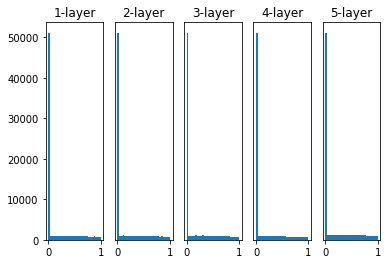

In [24]:
# 구현
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(x):
    return 1/(1+np.exp(-x))

def ReLU(x):
    return np.maximum(0, x)

x = np.random.randn(1000, 100)
node_num = 100
hidden_layer_size = 5
activations = {}

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]
    
    # W = np.random.randn(node_num, node_num)*1
    # W = np.random.randn(node_num, node_num)*0.01
    # W = np.random.randn(node_num, node_num)*np.sqrt(1.0/node_num)
    W = np.random.randn(node_num, node_num)*np.sqrt(2.0/node_num)

    a = np.dot(x, W)
    #z = sigmoid(a)
    z = ReLU(a)
    activations[i] = z

for i,a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1)+"-layer")

    if i != 0:
        plt.yticks([], [])
        
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

>> ![standard_deviation_1](standard_deviation_1.png)
>>  
>> * 층: 5개
>> * 각 층의 뉴런: 100개
>> * 입력 데이터: 1000개의 무작위 정규분포 데이터
>> * 활성화 함수: Sigmoid function
>> * 가중치 분포에 주의해야 함
>> * 위 구현에서는 표준편차가 1인 정규분포를 이용함, 이 분포된 정도(표준편차)를 바꿔가며 활성화값들의 분포가 어떻게 변화하는지 관찰하는 것이 이 실험의 목적
>> * 각 층의 활성화값들이 0과 1에 치우쳐 분포
>> * 위 구현에서 사용한 Sigmoid function은 그 출력이 0에 가까워지면 그 미분은 0에 다가감  
>> &nbsp; &nbsp; &rarr; 데이터가 0과 1에 치우쳐 분포하게 되면 역전파의 기울기 값이 점점 작아지다가 사라짐  
>> &nbsp; &nbsp; &rarr; 기울기 소실(gradient vanishing) 문제, 층을 깊게 하는 딥러닝에서는 기울기 소실은 더 심각한 문제가 될 수 있음
>>  

>> ![standard_deviation_0.01](standard_deviation_0.01.png)
>> * 표준편차를 0.01로 한 정규분포의 경우 각 층의 활성화값 분포
>> * 0.5 부근에 집중되어 있음  
>> &nbsp; &nbsp; &rarr; 0과 1로 치우치지는 않아 기울기 소실 문제는 일어나지 않지만, 활성화값들이 치우쳤다는 것은 표현력 관점에서는 큰 문제가 있음  
>> &nbsp; &nbsp; &rarr; 이 상황에서는 다수의 뉴런이 거의 같은 값을 출력하고 있으니 뉴런을 여러 개 둔 의미가 없어짐

>> 따라서 활성화값들이 치우치면 표현력을 제한한다는 관점에서 문제가 됨  
>> 각 층의 활성화값들은 적당히 고루 분포되어야 함  
>> 층과 층 사이에 적당하게 다양한 데이터가 흐르게 해야 신경망 학습이 효율적으로 진행되기 때문  
>> 반대로 치우친 데이터가 흐르면 기울기 소실이나 표현력 제한 문제에 빠져 학습이 잘 이루어지지 않음

>> Xavier 초깃값
>> * Xavier Glorot와 Yoshua Bengio의 논문에서 권장하는 가중치 초깃값
>> * 일반적인 딥러닝 프레임워크들이 표준적으로 이용
>> * 논문은 각 층의 활성화값들을 광범위하게 분포시킬 목적으로 가중치의 적절한 분포를 찾고자 함
>> * 앞 계층의 노드가 $n$ 개라면 표준편차가 $\frac{1}{\sqrt{n}}$ 인 분포를 사용하면 된다는 결론을 이끌어 냄
>>  
>> ![xavier](/pic/xavier.png)
>>   
>> Xavier 초깃값을 사용하면 앞 층에 노드가 많을수록 대상 노드의 초깃값으로 설정하는 가중치가 좁게 펴짐  
>>  
>> ![standard_deviation_xavier](pic/standard_deviation_xavier.png)
>>  
>> * 층이 깊어지면서 형태가 다소 일그러지지만, 앞에서 본 방식보다는 확실히 넓게 분포됨
>> * 각 층에 흐르는 데이터는 적당히 퍼져 있으므로, Sigmoid function의 표현력도 제한받지 않고 학습이 효율적으로 이루어질 것 
>> * 오른쪽으로 갈수록 일그러지는 것은 sigmoid function 대신 tanh function을 이용하면 개선됨
>> * tanh function도 sigmoid function과 같은 'S'자 모양 곡선 함수
>> * tanh function은 원점(0, 0)에서 대칭인 S곡선인 반면, sigmoid function은 (x,y) = (0, 0.5)에서 대칭인 S곡선
>> * 활성화 함수용으로는 원점에서 대칭인 함수가 바람직하다고 알려져 있음

>> ##### ReLU를 사용할 때의 가중치 초깃값
>> Xavier 초깃값은 활성화 함수가 선형인 것을 전제로 이끈 결과  
>> Sigmoid function과 tanh function 함수는 좌우 대칭이라 중앙 부근이 선형인 함수로 볼 수 있음  
>> &nbsp; &nbsp; &rarr; Xavier 초깃값이 적당함  
>>  
>> 반면 ReLU를 이용할 때는 ReLU에 특화된 초깃값을 이용하라고 권장  
>> 이 특화된 초깃값을 찾아낸 Kaiming He의 이름을 따 He 초깃값이라 함
>>
>> He 초깃값
>> * 앞 계층의 노드가 $n$ 개일 때, $\sqrt{\frac{2}{n}}$ 인 정규분포를 사용
>> * Xaiver 초깃값은 $\sqrt{\frac{2}{n}}$  
>> &nbsp; &nbsp; &rarr; ReLU는 음의 영역이 0이라서 더 넓게 분포시키기 위해 2배의 계수가 필요하다고 (직감적으로) 해석할 수 있음
>>  
>> ![activations_spread_relu](pic/activations_spread_relu.png)
>> 
>> 표준편차 = 0.01
>> * 각 층의 활성화값들은 아주 작은 값들
>> * 신경망에 아주 작은 데이터가 흐른다는 것은 역전파 때 가중치의 기울기 역시 작아진다는 뜻
>> &nbsp; &nbsp; &rarr; 이는 중대한 문제이며, 실제로도 학습이 거의 이뤄지지 않을 것
>>  
>> Xavier 초깃값
>> * 층이 깊어지면서 치우침이 조금씩 커짐
>> * 실제로 층이 깊어지면 활성화값들의 치우침도 커지고, 학습할 때 '기울기 소실' 문제를 일으킴
>>  
>> He 초깃값
>> * 모든 층에서 균일하게 분포
>> * 층이 깊어져도 분포가 균일하게 유지
>> &nbsp; &nbsp; &rarr; 역전파 때도 적절한 값이 나올 것으로 기대

>> 이상의 실험 결과를 바탕으로
>> * 활성화 함수: ReLU &rarr; He 초깃값
>>  
>> * 활성화 함수: Sigmoid, tanh (S자 모양 곡선) &rarr; Xavier 초깃값


>> ##### MNIST 데이터셋으로 본 가중치 초깃값 비교
>> 실제 데이터를 가지고 가중치의 초깃값을 주는 방법이 신경망 학습에 얼마나 영향을 주는지 알아볼 예정

===========iteration:0===========
std=0.01:2.3024906187624805
Xavier:2.320218334259964
He:2.467704672824771
===========iteration:100===========
std=0.01:2.302407607924717
Xavier:2.2693165464693013
He:1.6659291668038774
===========iteration:200===========
std=0.01:2.299268871180098
Xavier:2.159679372363867
He:0.8323954915906572
===========iteration:300===========
std=0.01:2.3027872971932233
Xavier:1.9232582139518815
He:0.5989196121360577
===========iteration:400===========
std=0.01:2.2995279093215624
Xavier:1.4276477205260458
He:0.47989956054138677
===========iteration:500===========
std=0.01:2.3028288613831824
Xavier:0.9761506033763876
He:0.3337547618581814
===========iteration:600===========
std=0.01:2.2999969447321544
Xavier:0.7853394580098316
He:0.31972473635706944
===========iteration:700===========
std=0.01:2.3044278206739097
Xavier:0.592332132318945
He:0.2646844760132683
===========iteration:800===========
std=0.01:2.3023929527358264
Xavier:0.4979003745233773
He:0.279881610354010

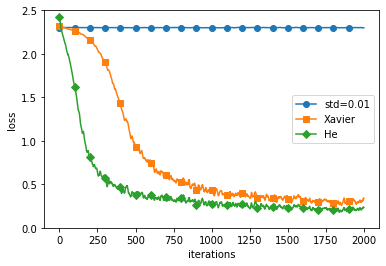

In [25]:
# 활성화 함수: ReLU
# 0.01, Xavier, He
import os, sys
sys.path.append(os.pardir)
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.util import smooth_curve
from common.multi_layer_net import MultiLayerNet
from common.optimizer import SGD

# 0. MNIST 데이터 읽기==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000


# 1. 실험용 설정==========
weight_init_types = {'std=0.01': 0.01, 'Xavier': 'sigmoid', 'He': 'relu'}
optimizer = SGD(lr=0.01)

networks = {}
train_loss = {}
for key, weight_type in weight_init_types.items():
    networks[key] = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100],
                                  output_size=10, weight_init_std=weight_type)
    train_loss[key] = []


# 2. 훈련 시작==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in weight_init_types.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizer.update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    if i % 100 == 0:
        print("===========" + "iteration:" + str(i) + "===========")
        for key in weight_init_types.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))


# 3. 그래프 그리기==========
markers = {'std=0.01': 'o', 'Xavier': 's', 'He': 'D'}
x = np.arange(max_iterations)
for key in weight_init_types.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 2.5)
plt.legend()
plt.show()

>> * 활성화 함수: ReLU
>>  
>> * `std=0.01`일 때는 학습이 전혀 이뤄지지 않음  
>> &nbsp; &nbsp; &rarr; 활성화 값의 분포에서 본 것처럼 순전파 때 너무 작은 값(0 근처로 밀집한 데이터)이 흐르기 때문  
>> &nbsp; &nbsp; &rarr; 역전파 때의 기울기도 작아져 가중치가 거의 갱신되지 않음  
>> * Xavier와 He의 경우는 학습이 순조롭게 이뤄지고 있음
>> &nbsp; &nbsp; &rarr; 학습 진도는 He가 더 빠름

>> 기중치의 초깃값은 신경망 학습에 아주 중요한 포인트  
>>  
>> 가중치의 초깃값에 따라 신경망 학습의 성패가 갈리는 경우가 많음  
>> 

> ### **6.3** 배치 정규화
>>  
>> 지금까지 각 층의 활성화값 분포를 관찰해보며, 가중치의 초깃값을 적절히 설정하면 각 층의 활성화값 분포가 적당히 퍼지면서 학습이 원활하게 수행됨을 배움
>>  
>> 그렇다면 각 층이 활성화를 적당히 퍼뜨리도록 '강제'하면 어떨까?  
>> &nbsp; &nbsp; &rarr; 배치 정규화(Batch Normalization)의 아이디어